In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
import threading

from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
)
from tensorflow.keras.utils import get_custom_objects, to_categorical
from tensorflow.keras.applications import ResNet50  # Using ResNet50 as an example for ViT alternative
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from keras_vggface.vggface import VGGFace  # Import VGGFace2 Model
from keras_vggface.utils import preprocess_input

# Suppress TensorFlow logs (only show errors)
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses INFO (1), WARNING (2), and ERROR (3)


2025-03-06 03:44:15.718732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-06 03:44:16.261909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the dataset
labels_df = pd.read_csv('AffectNet/labels.csv')
labels_df = labels_df[labels_df['label'] != 'contempt']

# Stratified train-test split to maintain class balance
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42, stratify=labels_df['label'])

print("Training Dataset : " + str(train_df['label'].value_counts()))
print("Validation Dataset : " + str(val_df['label'].value_counts()))

# Initialize face detection model
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Set the target image size (IMG_SIZE)
IMG_SIZE = 96

Training Dataset : label
surprise    3693
happy       3469
anger       2886
disgust     2777
fear        2434
sad         2396
neutral     2289
Name: count, dtype: int64
Validation Dataset : label
surprise    923
happy       867
anger       722
disgust     695
fear        609
sad         599
neutral     572
Name: count, dtype: int64


I0000 00:00:1741232658.135878   39817 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741232658.264519   39918 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA TITAN Xp/PCIe/SSE2


In [3]:
lock = threading.Lock()
def detect_and_crop_face(image):
    """Detects and crops the face using BlazeFace (MediaPipe), then resizes to target size."""
    with lock:
        if image is None:
            print("Empty")
            
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process the image with face detection
        results = face_detector.process(img_rgb)
    
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = image.shape
    
                # Calculate bounding box coordinates
                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                box_width = int(bboxC.width * w)
                box_height = int(bboxC.height * h)
    
                # Optionally expand the bounding box slightly
                x_min = max(0, x_min - box_width // 10)
                y_min = max(0, y_min - box_height // 10)
                box_width = min(w, box_width + box_width // 5)
                box_height = min(h, box_height + box_height // 5)
    
                # Crop the face from the image using the bounding box
                cropped_face = image[y_min:y_min + box_height, x_min:x_min + box_width]
                
                # Resize the cropped face to the target size (IMG_SIZE x IMG_SIZE)
                return cv2.resize(cropped_face, (IMG_SIZE, IMG_SIZE))
    
        # If no face detected, return resized version of the original image
        return cv2.resize(image, (IMG_SIZE, IMG_SIZE))

In [4]:
# Define emotion labels
emotion_labels = ['anger', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
num_classes = len(emotion_labels)  # 7 classes

def image_generator(dataframe, batch_size=32):
    while True:
        batch_images = []
        batch_labels = []
        
        dataframe = dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle at start of epoch

        for i in range(len(dataframe)):
            row = dataframe.iloc[i]
            img_path = os.path.join('AffectNet', row['pth'])  # Ensure path correctness
            image = cv2.imread(img_path)

            # Detect and crop the face
            face = detect_and_crop_face(image)
            if face is not None:
                batch_images.append(face)

                # Convert label from string to index
                label_str = row['label']
                if label_str not in emotion_labels:
                    print(f"Warning: Unexpected label '{label_str}' found!")
                    continue  # Skip if label is not in predefined list

                label_index = emotion_labels.index(label_str)  # Convert "happy" -> 4

                # Fix: Ensure correct shape for one-hot encoding
                one_hot_label = to_categorical(label_index, num_classes=num_classes)

                batch_labels.append(one_hot_label)

            # Yield batch when full
            if len(batch_images) == batch_size:
                yield np.array(batch_images).astype('float32') / 255.0, np.array(batch_labels)
                batch_images = []
                batch_labels = []

        # Yield remaining images if any
        if len(batch_images) > 0:
            yield np.array(batch_images).astype('float32') / 255.0, np.array(batch_labels)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1741232658.323302   39915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [5]:
x_batch, y_batch = next(image_generator(train_df, batch_size=32))
print("Batch X shape:", x_batch.shape)  # Expected: (batch_size, 96, 96, 3)
print("Batch Y shape:", y_batch.shape)  # Expected: (batch_size, 8) for one-hot labels

Batch X shape: (32, 96, 96, 3)
Batch Y shape: (32, 7)


In [6]:
# Identity Normalization (Idn) Module with Batch Normalization
def create_identity_normalization():
    inputs = keras.Input(shape=(96, 96, 3))
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return keras.Model(inputs, x, name="IdentityNormalization")

# Mixture of Experts (MoE) Module with Improved Gating
def create_moe(input_dim, num_experts=4, top_k=2, name="MoE"):
    inputs = keras.Input(shape=(input_dim,))
    experts = [layers.Dense(input_dim, activation="relu") for _ in range(num_experts)]
    
    gating_logits = layers.Dense(num_experts)(inputs)
    gating = layers.Softmax()(gating_logits)
    
    expert_outputs = tf.stack([experts[i](inputs) for i in range(num_experts)], axis=1)
    top_k_values, top_k_indices = tf.math.top_k(gating, k=top_k)

    output = tf.zeros_like(inputs)
    for i in range(top_k):
        expert_idx = top_k_indices[:, i]
        expert_out = tf.gather(expert_outputs, expert_idx, axis=1, batch_dims=1)
        output += tf.expand_dims(top_k_values[:, i], -1) * expert_out
    
    return keras.Model(inputs, output, name=name)

# CNN Feature Extractor with Dropout
def create_cnn_feature_extractor():
    inputs = keras.Input(shape=(96, 96, 3))
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor")

# Transformer Feature Extractor using ResNet50
def create_transformer_feature_extractor():
    inputs = keras.Input(shape=(96, 96, 3))
    base_model = ResNet50(input_shape=(96, 96, 3), include_top=False, weights="imagenet")(inputs)
    x = layers.GlobalAveragePooling2D()(base_model)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    return keras.Model(inputs, x, name="TransformerFeatureExtractor")

# Complete FER Model
def create_fer_model(num_classes=7):
    inputs = keras.Input(shape=(96, 96, 3))
    
    idn_model = create_identity_normalization()
    cnn_model = create_cnn_feature_extractor()
    transformer_model = create_transformer_feature_extractor()
    
    identity_features = idn_model(inputs)
    cnn_features = cnn_model(inputs)
    transformer_features = transformer_model(inputs)
    
    combined_features = layers.Concatenate()([cnn_features, transformer_features])
    dense_layer = layers.Dense(2048, activation="relu")(combined_features)
    dense_layer = layers.Dropout(0.3)(dense_layer)  # Prevent Overfitting
    
    idn_moe = create_moe(128, name="MoE_Identity")(identity_features)
    expression_moe = create_moe(2048, name="MoE_Expression")(dense_layer)
    
    final_features = layers.Concatenate()([idn_moe, expression_moe])
    output = layers.Dense(num_classes, activation="softmax")(final_features)
    
    return keras.Model(inputs, output, name="FER_IdentityAware_MoE")

# Compile and Initialize Model
num_classes = 7
model = create_fer_model(num_classes)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Update model checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('AffectNet-Ensemble-Vision-7classes2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.summary()


2025-03-06 03:44:19.262546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11242 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:19:00.0, compute capability: 6.1
2025-03-06 03:44:19.263196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5887 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:1a:00.0, compute capability: 6.1
2025-03-06 03:44:19.263715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 8239 MB memory:  -> device: 2, name: NVIDIA TITAN Xp, pci bus id: 0000:67:00.0, compute capability: 6.1
2025-03-06 03:44:19.264231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 11531 MB memory:  -> device: 3, name: NVIDIA TITAN Xp, pci bus id: 0000:68:00.0, comput

Model: "FER_IdentityAware_MoE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 CNNFeatureExtractor (Functiona  (None, 256)         127168      ['input_1[0][0]']                
 l)                                                                                               
                                                                                                  
 TransformerFeatureExtractor (F  (None, 512)         24636800    ['input_1[0][0]']                
 unctional)                                                                                       
                                                                              

In [7]:
history = model.fit(
    image_generator(train_df, batch_size=32),
    steps_per_epoch=len(train_df) // 32,  # Ensure correct number of steps
    epochs=30,
    validation_data=image_generator(val_df, batch_size=32),
    validation_steps=len(val_df) // 32,
    callbacks=[checkpoint]
)

Epoch 1/30


2025-03-06 03:44:22.114502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-03-06 03:44:33.541017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2025-03-06 03:44:34.132512: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f8a1c187310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-06 03:44:34.132561: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2025-03-06 03:44:34.132577: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA TITAN Xp, Compute Capability 6.1
2025-03-06 03:44:34.132590: I tensorflow/compiler/xla/service/service

623/623 [==============================] - ETA: 0s - loss: 1.3221 - accuracy: 0.4925

2025-03-06 03:49:02.858667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.23044, saving model to AffectNet-Ensemble-Vision-7classes2.h5
623/623 [==============================] - 346s 506ms/step - loss: 1.3221 - accuracy: 0.4925 - val_loss: 1.9276 - val_accuracy: 0.2304
Epoch 2/30
623/623 [==============================] - ETA: 0s - loss: 0.8288 - accuracy: 0.7005
Epoch 2: val_accuracy improved from 0.23044 to 0.63810, saving model to AffectNet-Ensemble-Vision-7classes2.h5
623/623 [==============================] - 316s 507ms/step - loss: 0.8288 - accuracy: 0.7005 - val_loss: 0.9710 - val_accuracy: 0.6381
Epoch 3/30
623/623 [==============================] - ETA: 0s - loss: 0.5313 - accuracy: 0.8110
Epoch 3: val_accuracy improved from 0.63810 to 0.66190, saving model to AffectNet-Ensemble-Vision-7classes2.h5
623/623 [==============================] - 315s 506ms/step - loss: 0.5313 - accuracy: 0.8110 - val_loss: 1.0146 - val_accuracy: 0.6619
Epoch 4/30
623/623 [==============================] - ETA: 0s - loss: 0.

In [8]:
import os
import cv2
import numpy as np

# Assuming 'detect_and_crop_face' is a pre-defined function for face detection and cropping
def preprocess_and_predict_concatenated_model(model, dataframe):
    images = []
    labels = []

    # List of emotion labels corresponding to each model output
    emotion_labels = ['anger', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']

    # Loop through each row of the dataframe
    for _, row in dataframe.iterrows():
        img_path = os.path.join('AffectNet', row['pth'])  # Adjust path if needed
        image = cv2.imread(img_path)

        # Apply face detection and cropping
        face = detect_and_crop_face(image)
        if face is not None:
            images.append(face.astype('float32') / 255.0)  # Normalize image to [0, 1]
            
            # Convert label to binary vector for each emotion
            labels.append([1 if row['label'] == emotion else 0 for emotion in emotion_labels])

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Predict using the concatenated model
    y_pred = model.predict(images)

    # Use argmax to find the index of the highest output for each prediction
    predicted_indices = np.argmax(y_pred, axis=-1)  # Get index of the highest value (emotion)

    # Map the predicted indices to emotion labels
    predicted_emotions = [emotion_labels[i] for i in predicted_indices]

    return labels, predicted_emotions  # Return both true labels and predicted emotions


In [9]:
model.load_weights('AffectNet-Ensemble-Vision-7classes2.h5')

In [10]:
y_true, y_pred_classes = preprocess_and_predict_concatenated_model(model, val_df)

156/156 [==============================] - 4s 22ms/step


In [11]:
# Convert true labels from binary vectors to emotion labels
emotion_labels = ['anger', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
y_true_labels = [' '.join([emotion_labels[i] for i, val in enumerate(row) if val == 1]) for row in y_true]

# Print classification report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

       anger       0.69      0.63      0.66       722
     disgust       0.65      0.67      0.66       695
        fear       0.67      0.65      0.66       609
       happy       0.90      0.89      0.89       867
     neutral       0.60      0.63      0.62       572
         sad       0.66      0.58      0.62       599
    surprise       0.65      0.74      0.69       923

    accuracy                           0.70      4987
   macro avg       0.69      0.68      0.69      4987
weighted avg       0.70      0.70      0.70      4987



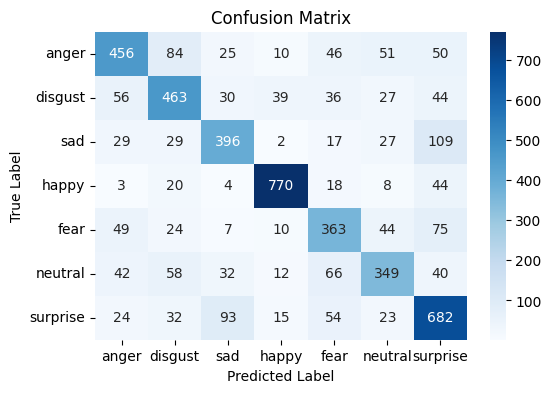

In [12]:
# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_classes)

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

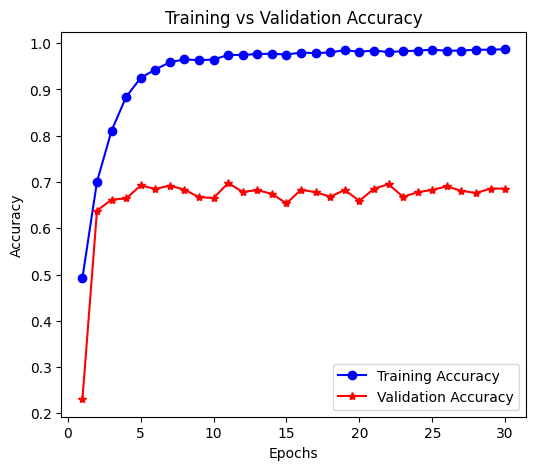

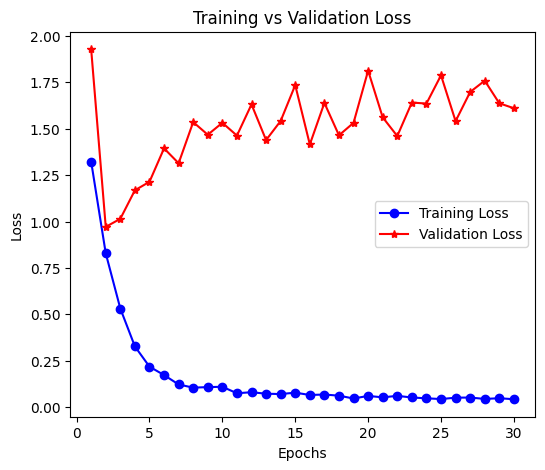

In [13]:
import matplotlib.pyplot as plt

# Define epochs based on history length
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot Training vs Validation Accuracy
plt.figure(figsize=(6, 5))
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot Training vs Validation Loss
plt.figure(figsize=(6, 5))
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()